# Part 2, Model 2A: Glaucoma Detection using K-Nearest Neighbors (KNN), XgBoost and a linear C-Support Vector Classification (SVM classifier) on JUST the fundus images of the eye and the selected features using statistical analysis. The features were extracted using the MobileNetV3 model.

In [279]:
%pip install scikit-learn
%pip install seaborn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [280]:
import os
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
import keras

from pathlib import Path

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd


In [281]:
tf.__version__

'2.15.0'

In [282]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('metadata - standardized.csv')

In [283]:
data.columns

Index(['names', 'types', 'type_expanded', 'isColor', 'original_name',
       'patient_id', 'fundus', 'fundus_od_seg', 'fundus_oc_seg', 'bv_seg',
       'artery_seg', 'vein_seg', 'oct', 'oct_oc_seg', 'oct_od_seg', 'sex',
       'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr',
       'Unnamed: 24', 'notchI_present', 'notchS_present', 'notchN_present',
       'notchT_present', 'expert1_grade', 'expert2_grade', 'expert3_grade',
       'expert4_grade', 'expert5_grade', 'cdr_avg', 'cdr_expert1',
       'cdr_expert2', 'cdr_expert3', 'cdr_expert4', 'refractive_dioptre_1',
       'refractive_dioptre_2', 'refractive_astigmatism',
       'phakic_or_pseudophakic', 'iop_perkins', 'iop_pneumatic', 'pachymetry',
       'axial_length', 'visual_field_mean_defect'],
      dtype='object')

In [284]:
data.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [285]:
data['fundus_oc_seg'].dtype

dtype('O')

In [286]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [287]:
print(data['fundus'][12044])
print(data['fundus_oc_seg'][12044])
print(data['fundus_od_seg'][12044])

/full-fundus/PAPILA-484.png
/optic-cup/PAPILA-484.png
/optic-disc/PAPILA-484.png


full-fundus/full-fundus/PAPILA-484.png


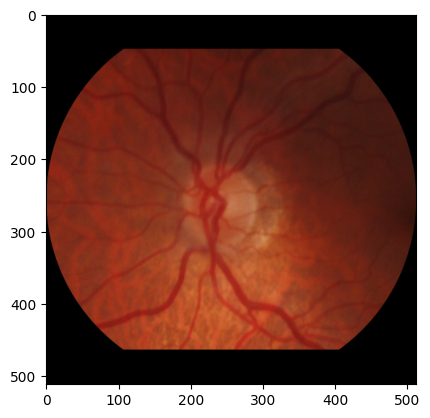

In [288]:
def viewFundus(image_path):

    image_path = 'full-fundus' + image_path

    print(image_path)

    image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('on')
    plt.show()

viewFundus(data['fundus'][12044])

In [289]:
data[['gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gender   488 non-null    float64
 1   age      5004 non-null   float64
 2   eye      5733 non-null   object 
 3   sbp      22 non-null     float64
 4   dbp      22 non-null     float64
 5   hr       22 non-null     float64
 6   iop      22 non-null     float64
 7   vcdr     650 non-null    float64
 8   cdr_avg  101 non-null    float64
dtypes: float64(8), object(1)
memory usage: 875.4+ KB


In [290]:
print(data.describe())

              types  isColor      gender          age         sbp        dbp  \
count  12449.000000  12449.0  488.000000  5004.000000   22.000000  22.000000   
mean       0.372239      1.0    0.618852    57.519784  155.727273  77.090909   
std        0.505039      0.0    0.486167    11.668287   60.323084  11.863947   
min       -1.000000      1.0    0.000000     1.000000  107.000000  47.000000   
25%        0.000000      1.0    0.000000    50.000000  129.250000  71.250000   
50%        0.000000      1.0    1.000000    58.000000  150.500000  79.500000   
75%        1.000000      1.0    1.000000    65.000000  156.000000  83.250000   
max        1.000000      1.0    1.000000    91.000000  412.000000  95.000000   

              hr        iop        vcdr  Unnamed: 24  ...  expert1_grade  \
count  22.000000  22.000000  650.000000          0.0  ...     101.000000   
mean   67.000000  14.818182    0.576308          NaN  ...       0.722772   
std    10.235326   3.403589    0.116395          Na

count    5004.000000
mean       57.519784
std        11.668287
min         1.000000
25%        50.000000
50%        58.000000
75%        65.000000
max        91.000000
Name: age, dtype: float64


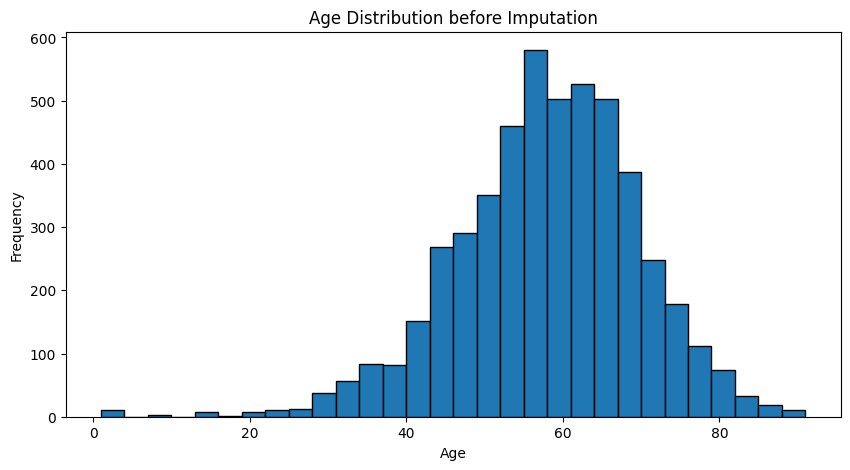

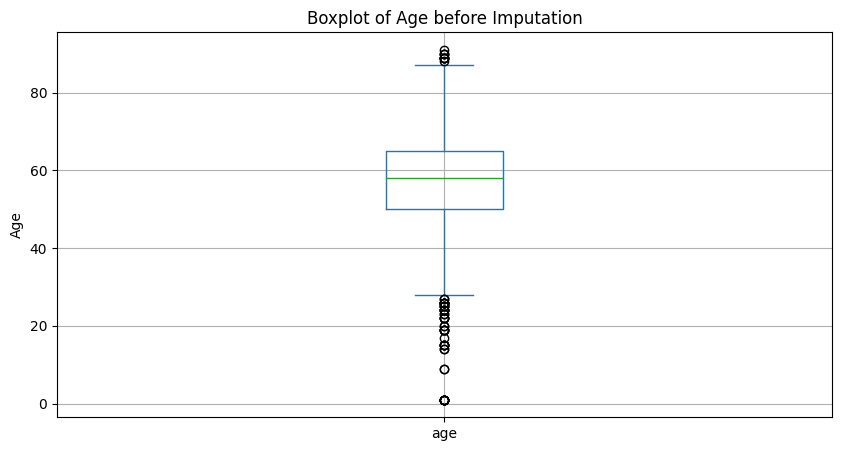

In [291]:
import pandas as pd
import matplotlib.pyplot as plt

summary_stats_before = data['age'].describe()
print(summary_stats_before)

plt.figure(figsize=(10, 5))
data['age'].hist(bins=30, edgecolor='black')
plt.title('Age Distribution before Imputation')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

plt.figure(figsize=(10, 5))
data['age'].plot(kind='box')
plt.title('Boxplot of Age before Imputation')
plt.ylabel('Age')
plt.grid(True)
plt.show()

In [293]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [297]:
import numpy as np
import pandas as pd
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

data = data.dropna(axis=1, how='all')

data['eye'] = data['eye'].replace({'OD': 0, 'OS': 1})

for col in ['gender', 'eye']:
    if col in data.columns:
        mode = data[col].mode()[0]
        data[col] = data[col].fillna(mode)

numerical_data = data.select_dtypes(include=[np.number])

rf_regressor = RandomForestRegressor(
    n_estimators=150,
    max_features='sqrt',
    n_jobs=-1,
    random_state=None
)

imp = IterativeImputer(
    estimator=rf_regressor,
    max_iter=10,
    random_state=None
)

numerical_data_imputed = imp.fit_transform(numerical_data)

numerical_data_imputed = pd.DataFrame(numerical_data_imputed, columns=numerical_data.columns, index=numerical_data.index)

integer_columns = ['types', 'isColor', 'gender', 'eye', 'age']
for col in integer_columns:
    if col in numerical_data_imputed.columns:
        numerical_data_imputed[col] = numerical_data_imputed[col].round().astype('Int64')

non_numerical_data = data.select_dtypes(exclude=[np.number])
data_imputed = pd.concat([numerical_data_imputed, non_numerical_data], axis=1)

data_imputed = data_imputed.loc[data.index]

print("Shape of imputed data:", data_imputed.shape)

Shape of imputed data: (12449, 47)


/root/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [298]:
print(data_imputed.describe())

          types  isColor    gender        age       eye           sbp  \
count   12449.0  12449.0   12449.0    12449.0   12449.0  12449.000000   
mean   0.372239      1.0  0.985059  59.816772   0.77444    196.212654   
std    0.505039      0.0  0.121322   8.125566  0.417968     67.335766   
min        -1.0      1.0       0.0        1.0       0.0    107.000000   
25%         0.0      1.0       1.0       59.0       1.0    147.126667   
50%         0.0      1.0       1.0       62.0       1.0    148.293333   
75%         1.0      1.0       1.0       62.0       1.0    299.813333   
max         1.0      1.0       1.0       91.0       1.0    412.000000   

                dbp            hr           iop          vcdr  ...  \
count  12449.000000  12449.000000  12449.000000  12449.000000  ...   
mean      76.437642     68.032760     15.566256      0.563772  ...   
std        9.213128      8.768668      1.401599      0.101242  ...   
min       47.000000     51.000000      8.000000      0.161000 

In [299]:
data = data_imputed

data.tail()

,types,isColor,gender,age,eye,sbp,dbp,hr,iop,vcdr,...,sex,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
12444,0,1,1,59,1,300.42,62.793333,57.893333,16.346667,0.384604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12445,0,1,1,59,1,300.42,62.793333,57.893333,16.346667,0.384604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12446,0,1,1,59,1,300.42,62.793333,57.893333,16.346667,0.384604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12447,0,1,1,59,1,300.42,62.793333,57.893333,16.346667,0.384604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12448,0,1,1,59,1,300.42,62.793333,57.893333,16.346667,0.384604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


count      12449.0
mean     59.816772
std       8.125566
min            1.0
25%           59.0
50%           62.0
75%           62.0
max           91.0
Name: age, dtype: Float64


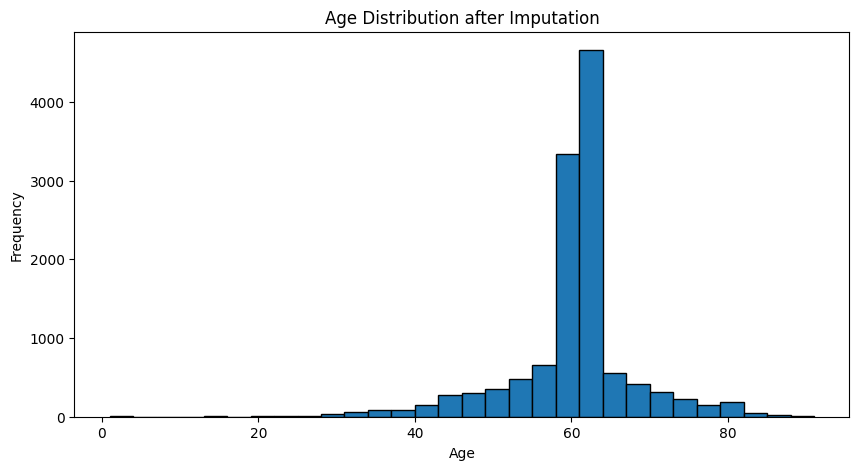

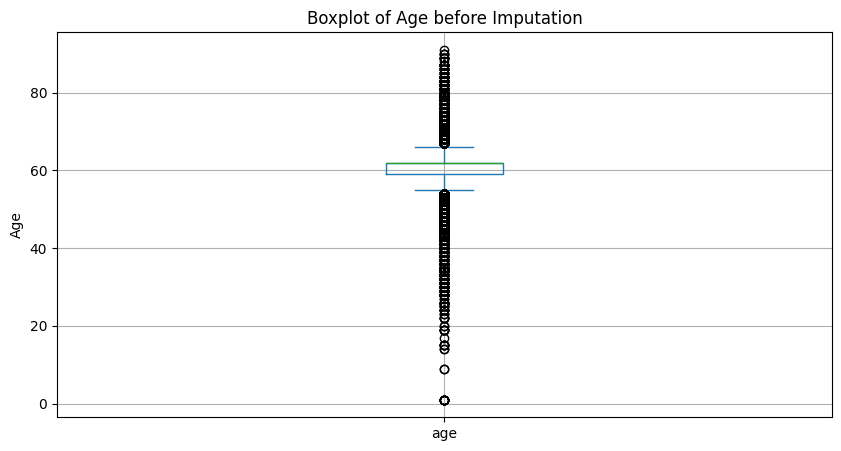

In [303]:
import pandas as pd
import matplotlib.pyplot as plt

summary_stats_before = data['age'].describe()
print(summary_stats_before)

plt.figure(figsize=(10, 5))
data['age'].hist(bins=30, edgecolor='black')
plt.title('Age Distribution after Imputation')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

plt.figure(figsize=(10, 5))
data['age'].plot(kind='box')
plt.title('Boxplot of Age After Imputation')
plt.ylabel('Age')
plt.grid(True)
plt.show()

In [305]:
data = data[
    
    (data['fundus'].notnull()) & (data['types'] != -1)
    
]

fundus_subset = data[['types', 'fundus', 'names']]

fundus_subset['combined'] = fundus_subset['names'] + '.png'

fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)

fundus_subset['types'] = fundus_subset['types'].astype(str)

fundus_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12316 entries, 0 to 12448
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   types     12316 non-null  object
 1   fundus    12316 non-null  object
 2   names     12316 non-null  object
 3   combined  12316 non-null  object
dtypes: object(4)
memory usage: 481.1+ KB


/tmp/ipykernel_11176/2031867355.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundus_subset['combined'] = fundus_subset['names'] + '.png'
/tmp/ipykernel_11176/2031867355.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)
/tmp/ipykernel_11176/2031867355.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [308]:
fundus_subset

,types,fundus,names,combined
0,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,OIA-ODIR-TEST-OFFLINE-1,OIA-ODIR-TEST-OFFLINE-1.png
1,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,OIA-ODIR-TEST-OFFLINE-2,OIA-ODIR-TEST-OFFLINE-2.png
2,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,OIA-ODIR-TEST-OFFLINE-4,OIA-ODIR-TEST-OFFLINE-4.png
3,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,OIA-ODIR-TEST-OFFLINE-5,OIA-ODIR-TEST-OFFLINE-5.png
4,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,OIA-ODIR-TEST-OFFLINE-6,OIA-ODIR-TEST-OFFLINE-6.png
...,...,...,...,...
12444,0,/full-fundus/FIVES-396.png,FIVES-396,FIVES-396.png
12445,0,/full-fundus/FIVES-397.png,FIVES-397,FIVES-397.png
12446,0,/full-fundus/FIVES-398.png,FIVES-398,FIVES-398.png
12447,0,/full-fundus/FIVES-399.png,FIVES-399,FIVES-399.png


In [309]:
from sklearn.model_selection import StratifiedShuffleSplit

glaucomaCount = len(fundus_subset[fundus_subset['types'] == '1.0'])
healthyCount = len(fundus_subset[fundus_subset['types'] == '0.0'])

print("this is the glaucoma count", glaucomaCount)
print("this is the healthy eyes count", healthyCount)

test_percentage = 0.20
val_percentage_from_train = 0.15

random_state = 1

stratified_split_test = StratifiedShuffleSplit(n_splits=1, test_size=test_percentage, random_state=random_state)

for train_index, test_index in stratified_split_test.split(fundus_subset, fundus_subset['types']):
    train_set_temp = fundus_subset.iloc[train_index]
    test = fundus_subset.iloc[test_index]

stratified_split_val = StratifiedShuffleSplit(n_splits=1, test_size=val_percentage_from_train, random_state=random_state)

for train_index, val_index in stratified_split_val.split(train_set_temp, train_set_temp['types']):
    train = train_set_temp.iloc[train_index]
    val = train_set_temp.iloc[val_index]

print("\nTotal fundus images to be used:", len(fundus_subset))
print("\nTrain set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

train_features = train.drop('types', axis=1)
train_labels = train['types']
val_features = val.drop('types', axis=1)
val_labels = val['types']
test_features = test.drop('types', axis=1)
test_labels = test['types']

this is the glaucoma count 0
this is the healthy eyes count 0

Total fundus images to be used: 12316

Train set size: 8374
Validation set size: 1478
Test set size: 2464


In [310]:
print("Train Size: ", len(train))
print("Test Size: ", len(test))

Train Size:  8374
Test Size:  2464


In [311]:
data.head()

,types,isColor,gender,age,eye,sbp,dbp,hr,iop,vcdr,...,sex,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,0,1,1,58,0,299.900000,63.766667,58.640000,16.353333,0.538966,...,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,1,60,1,147.586667,78.006667,64.753333,16.886667,0.583196,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1,1,66,1,139.173333,84.593333,71.026667,16.086667,0.635179,...,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1,1,70,0,153.386667,82.846667,68.486667,15.440000,0.613903,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1,1,45,1,214.680000,73.453333,61.300000,16.886667,0.568501,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [312]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [313]:
import tensorflow as tf
from tensorflow import keras
from keras.layers.experimental.preprocessing import Rescaling
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 

target = 224
batchSize = 8

classes = 'binary'

with tf.device('/GPU:0'):


    trainDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen = trainDataGen.flow_from_dataframe(dataframe=train, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    valDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen = valDataGen.flow_from_dataframe(dataframe=val,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    testDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen = testDataGen.flow_from_dataframe(dataframe=test,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

Found 8374 validated image filenames belonging to 2 classes.
Found 1478 validated image filenames belonging to 2 classes.
Found 2464 validated image filenames belonging to 2 classes.


In [315]:
fundus_subset_random = fundus_subset.sample(frac=1, random_state=1)

healthy_subset = fundus_subset_random[fundus_subset_random['types'] == '0']
glaucoma_subset = fundus_subset_random[fundus_subset_random['types'] == '1']

with tf.device('/GPU:0'):

    classes = 'sparse'

    healthy_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    healthy_subset_Gen = healthy_subsetDataGen.flow_from_dataframe(dataframe=healthy_subset, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    glaucoma_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    glaucoma_subset_Gen = glaucoma_subsetDataGen.flow_from_dataframe(dataframe=glaucoma_subset, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')

Found 7549 validated image filenames belonging to 1 classes.
Found 4767 validated image filenames belonging to 1 classes.


In [316]:
def show_images(gen):
    
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)

    length = len(labels)
    sample = min(length, 25)

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(4, 4, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

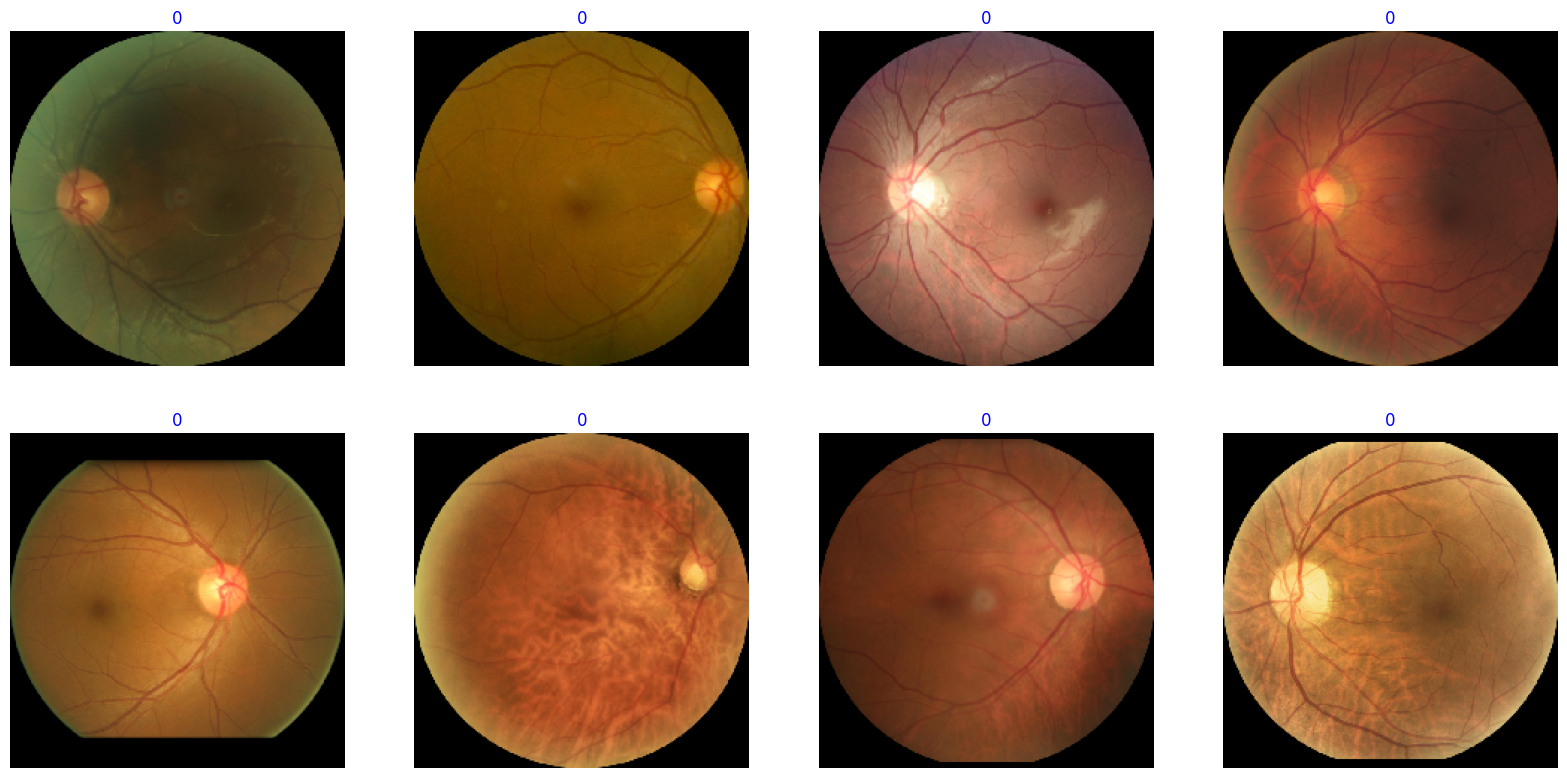

In [317]:
show_images(healthy_subset_Gen)

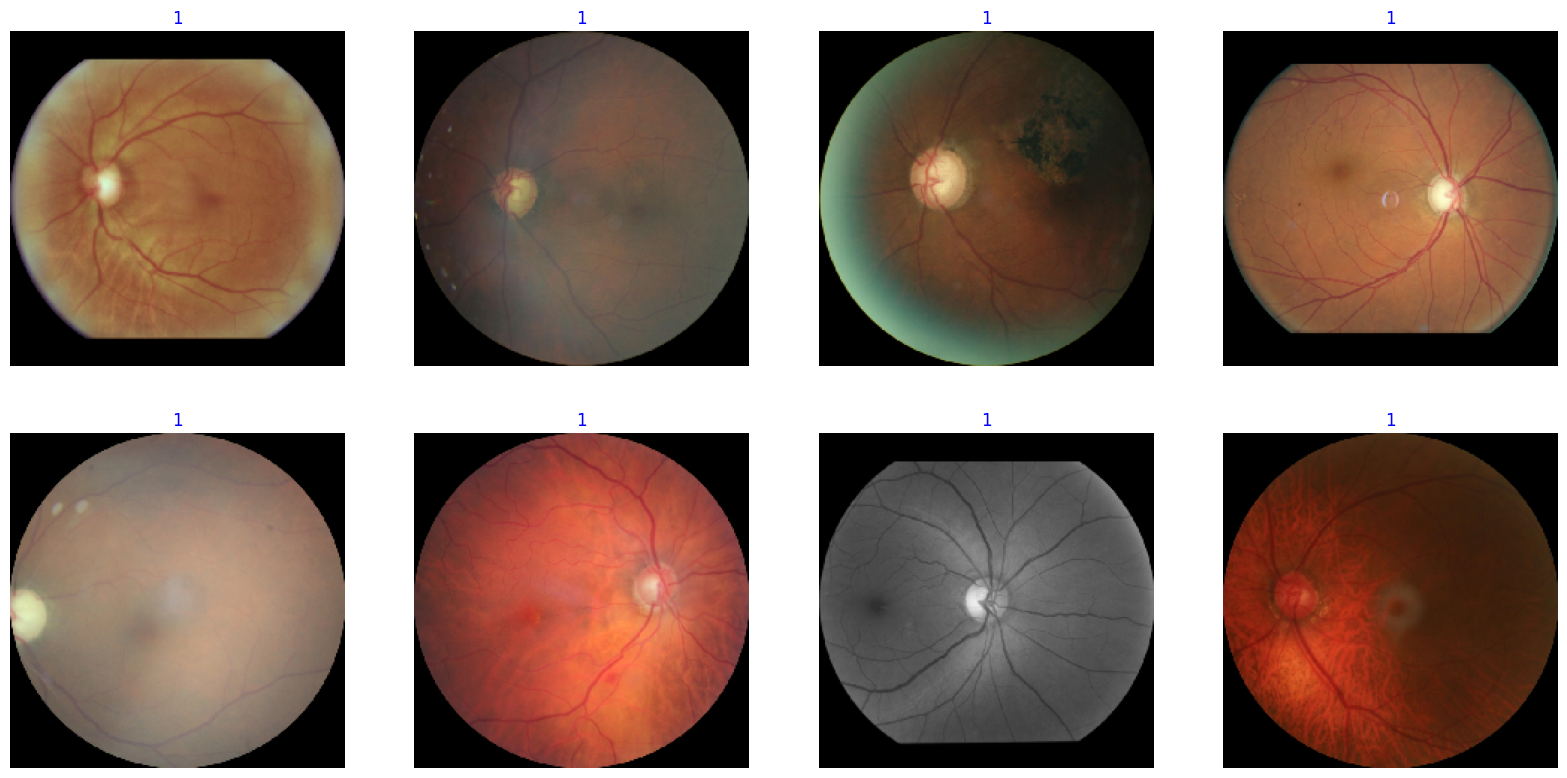

In [318]:
show_images(glaucoma_subset_Gen)

In [319]:
from keras.applications import MobileNetV3Small
from keras import Sequential

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(target, target, 3))

model = Sequential([
    base_model, layers.GlobalAveragePooling2D()
])

def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, model.layers[-1].output.shape[1]))
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features[i * batchSize: (i + 1) * batchSize] = features_batch
        labels[i * batchSize: (i + 1) * batchSize] = labels_batch
        i += 1
        if i * batchSize >= sample_count:
            break
    return features, labels

In [320]:
import numpy as np

def combine_features(extracted_features, labels, generator_indices, non_image_data):

    non_image_features = non_image_data.iloc[generator_indices].to_numpy()
    combined_features = np.concatenate((extracted_features, non_image_features), axis=1)
    
    return combined_features, labels

train_features, train_labels = extract_features(trainGen, trainGen.samples)
val_features, val_labels = extract_features(valGen, valGen.samples)
test_features, test_labels = extract_features(testGen, testGen.samples)

non_image_features = data[['gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg']]

train_features_combined, train_labels = combine_features(train_features, train_labels, trainGen.index_array, non_image_features)
val_features_combined, val_labels = combine_features(val_features, val_labels, valGen.index_array, non_image_features)
test_features_combined, test_labels = combine_features(test_features, test_labels, testGen.index_array, non_image_features)

1/1 [==============================] - 0s 24ms/step


In [321]:
train_features_combined

array([[-0.008968135342001915, 2.076742649078369, -0.10437972098588943,
        ..., 16.346666666666668, 0.38460387069097945,
        0.43816666666666665],
       [0.17172138392925262, 1.660498023033142, 0.023506522178649902,
        ..., 16.506666666666668, 0.5831213333333335, 0.7664500000000001],
       [-0.0262299794703722, 0.6498700976371765, -0.00970684178173542,
        ..., 16.346666666666668, 0.38460387069097945,
        0.43816666666666665],
       ...,
       [0.13752391934394836, 1.542248010635376, 0.4021373987197876, ...,
        18.126666666666665, 0.7097, 0.8305166666666655],
       [-0.0, 0.04076414555311203, 0.037616390734910965, ...,
        14.006666666666666, 0.6436826666666665, 0.8260166666666664],
       [0.04950997605919838, 3.902548313140869, 0.7884376645088196, ...,
        16.346666666666668, 0.38460387069097945, 0.43816666666666665]],
      dtype=object)

In [322]:
from sklearn.svm import SVC

with tf.device('/GPU:0'):

    svm_model = SVC(kernel='linear', probability=True)
    svm_model.fit(train_features_combined, train_labels)

In [323]:
val_accuracy = svm_model.score(val_features_combined, val_labels)
print('Validation accuracy:', val_accuracy)

test_accuracy = svm_model.score(test_features_combined, test_labels)
print('Test accuracy:', test_accuracy)

Validation accuracy: 0.8437077131258457
Test accuracy: 0.8376623376623377


In [324]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = svm_model.predict(test_features_combined)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[1353  157]
 [ 243  711]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87      1510
         1.0       0.82      0.75      0.78       954

    accuracy                           0.84      2464
   macro avg       0.83      0.82      0.83      2464
weighted avg       0.84      0.84      0.84      2464



In [325]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=8, 
                                 weights='distance', 
                                 algorithm='auto', 
                                 leaf_size=30, 
                                 p=2, 
                                 metric='minkowski', 
                                 n_jobs=-1)

knn_model.fit(train_features_combined, train_labels)

KNeighborsClassifier(n_jobs=-1, n_neighbors=8, weights='distance')

In [326]:
val_accuracy = knn_model.score(val_features_combined, val_labels)
print('Validation accuracy:', val_accuracy)

test_accuracy = knn_model.score(test_features_combined, test_labels)
print('Test accuracy:', test_accuracy)

Validation accuracy: 0.7564276048714479
Test accuracy: 0.7467532467532467


In [327]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = knn_model.predict(test_features_combined)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[1352  158]
 [ 466  488]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.90      0.81      1510
         1.0       0.76      0.51      0.61       954

    accuracy                           0.75      2464
   macro avg       0.75      0.70      0.71      2464
weighted avg       0.75      0.75      0.73      2464



In [328]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(train_features_combined, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [329]:
val_accuracy = xgb_model.score(val_features_combined, val_labels)
print('Validation accuracy:', val_accuracy)

test_accuracy = xgb_model.score(test_features_combined, test_labels)
print('Test accuracy:', test_accuracy)

Validation accuracy: 0.8457374830852503
Test accuracy: 0.8388798701298701


In [330]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = xgb_model.predict(test_features_combined)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[1361  149]
 [ 248  706]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87      1510
         1.0       0.83      0.74      0.78       954

    accuracy                           0.84      2464
   macro avg       0.84      0.82      0.83      2464
weighted avg       0.84      0.84      0.84      2464



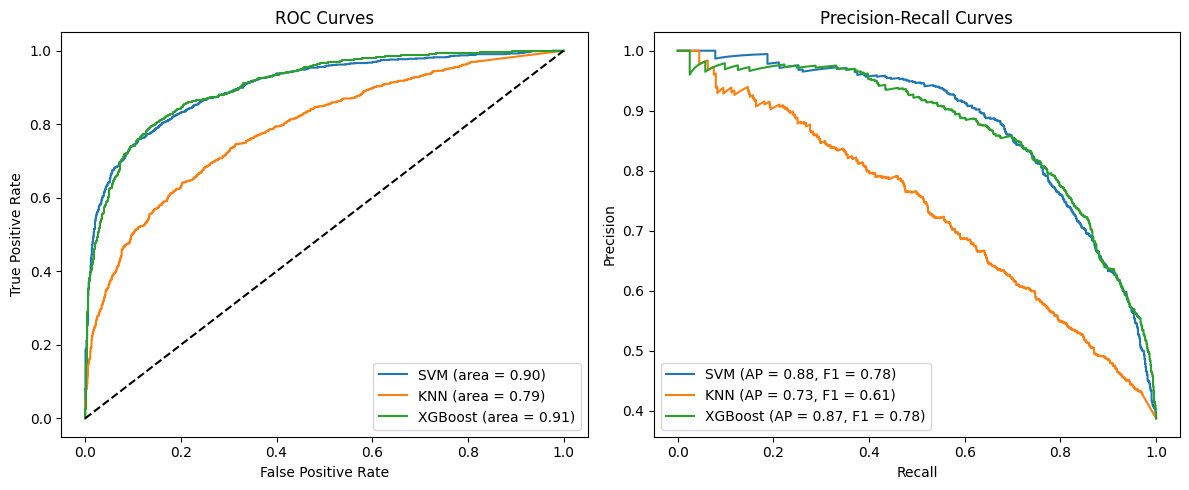

In [331]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, average_precision_score
import matplotlib.pyplot as plt

true_labels = test_labels
svm_probs = svm_model.predict_proba(test_features_combined)[:, 1]

knn_probs = knn_model.predict_proba(test_features_combined)[:, 1]

xgb_probs = xgb_model.predict_proba(test_features_combined)[:, 1]

fpr_svm, tpr_svm, _ = roc_curve(true_labels, svm_probs)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_knn, tpr_knn, _ = roc_curve(true_labels, knn_probs)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_xgb, tpr_xgb, _ = roc_curve(true_labels, xgb_probs)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

precision_svm, recall_svm, _ = precision_recall_curve(true_labels, svm_probs)
ap_svm = average_precision_score(true_labels, svm_probs)
f1_svm = f1_score(true_labels, svm_probs.round())

precision_knn, recall_knn, _ = precision_recall_curve(true_labels, knn_probs)
ap_knn = average_precision_score(true_labels, knn_probs)
f1_knn = f1_score(true_labels, knn_probs.round())

precision_xgb, recall_xgb, _ = precision_recall_curve(true_labels, xgb_probs)
ap_xgb = average_precision_score(true_labels, xgb_probs)
f1_xgb = f1_score(true_labels, xgb_probs.round())

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (area = {roc_auc_svm:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (area = {roc_auc_knn:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall_svm, precision_svm, label=f'SVM (AP = {ap_svm:.2f}, F1 = {f1_svm:.2f})')
plt.plot(recall_knn, precision_knn, label=f'KNN (AP = {ap_knn:.2f}, F1 = {f1_knn:.2f})')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AP = {ap_xgb:.2f}, F1 = {f1_xgb:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()